# Script description
### Input
* MongoDB database provided by Michiel Aernouts. This database contains metadata of the Belair sensors installed on bpost vans using the LoRa network. 
* This database contains the following elements:
    * _id: this is a unique ID generated for this packet 
    * device: unique ID for the device that sent the packet 
    * gateways: a list of the gateways that picked up the packet with their respective parameters (max 3) 
    * gpsLat and gpsLon: location 
    * hdop: measure for the correctness of the location 
    * rx_time: time of reception of the packet 
    * seqNumber: sequence number for the packets 
    * spfact: Spreading factor

### Plots
One of the things that was noticed in the past is that the quality of the LoRa network depends on the location in the city. Another thing that needs to be investigated is whether or not the signal quality varies over time. The signal quality of the LoRa network is related to the spreading factor. The following plots are made to investigate spatial and temporal influences:
* Plot of 1000 random samples to get a first idea
* Choropleth of the average spreading factor per district of Antwerp
* Choropleth of the average spreading factor based on 3 differently sized grid structures of Antwerp

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Create a Mongo Client and load data

In [2]:
import os
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import pymongo
from pymongo import MongoClient
import folium
import json
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopandas as gpd
from matplotlib import pyplot as plt
import time
from datetime import datetime
from datetime import timedelta  
from selenium import webdriver
from scipy import special, optimize
from IPython.display import Math
import math
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import export_png

In [3]:
print("Pymongo version: " + pymongo.__version__)
client = MongoClient('localhost', 27017)
db = client.Belair
collection = db.data

# Extract data, sort by timestamp and reset indexes
df = pd.DataFrame(list(collection.find())).reset_index(drop=True)
print(len(df))
df.head()

Pymongo version: 3.7.2
193008


,_id,device,gateways,gpsLat,gpsLon,hdop,rx_time,seqNumber,spfact
0,5c17af0d4fa20f164de4b0bb,3432333852378918,"[{'rssi': -93, 'esp': -93.461838, 'snr': 10, '...",51.194618,4.418419,0.66,2018-12-17 14:13:33.410,54916,7
1,5c17af2d4fa20f164de4b0c7,3432333852378918,"[{'rssi': -104, 'esp': -104.331955, 'snr': 11,...",51.194618,4.418417,0.69,2018-12-17 14:14:04.616,54917,7
2,5c17af424fa20f164de4b0cf,3432333864377C18,"[{'rssi': -110, 'esp': -111.764351, 'snr': 3, ...",51.215313,4.408513,1.02,2018-12-17 14:14:26.937,8823,8
3,5c17af4d4fa20f164de4b0d4,3432333852378918,"[{'rssi': -107, 'esp': -107.973228, 'snr': 6, ...",51.194614,4.418419,0.74,2018-12-17 14:14:36.499,54918,7
4,5c17af604fa20f164de4b0df,3432333851378918,"[{'rssi': -114, 'esp': -119.455406, 'snr': -4,...",51.241817,4.430120,0.66,2018-12-17 14:14:56.056,48522,7


# Plot 1 - 1000 random samples
The first visualization takes 1000 random samples and plots them on the map according to the SF. This gives a first idea of the variability of the SF in Antwerp.

In [4]:
def color_producer(spf):
    if spf == 7:
        return 'darkgreen'
    elif spf == 8:
        return 'green'
    elif spf == 9:
        return 'yellow'
    elif spf == 10:
        return 'orange'
    elif spf == 11:
        return 'red'
    elif spf == 12:
        return 'darkred'
    else:
        return 'black'

In [6]:
def scatter_plot_spf(df):
    mp = folium.Map(location=[df['gpsLat'].mean(), df['gpsLon'].mean()], 
                    zoom_start=13)

    # Generate legend
    legend_html = '''
         <div style="position: fixed; 
                     bottom: 50px; left: 50px; width: 100px; height: 150px; 
                     border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
                     ">&nbsp; <b> Legend </b> <br>
                     &nbsp; SPF 7 &nbsp; <i class="fa fa-circle" style="color:darkgreen"></i><br>
                     &nbsp; SPF 8 &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
                     &nbsp; SPF 9 &nbsp; <i class="fa fa-circle" style="color:yellow"></i><br>
                     &nbsp; SPF 10 &nbsp; <i class="fa fa-circle" style="color:orange"></i><br>
                     &nbsp; SPF 11 &nbsp; <i class="fa fa-circle" style="color:red"></i><br>
                     &nbsp; SPF 12 &nbsp; <i class="fa fa-circle" style="color:darkred"></i>
          </div>
         '''
    # Add legend to map
    mp.get_root().html.add_child(folium.Element(legend_html))
    
    # Extract latitude, longitude and spreading factor
    lat = list(df["gpsLat"])
    lon = list(df["gpsLon"])
    spf = list(df["spfact"])
    time = list(df["rx_time"])
    device = list(df["device"])

    fg = folium.FeatureGroup(name="Scatter plot Spreading Factor")
    
    # Add circles for every data point
    for lt, ln, sp, ti, dev in zip(lat, lon, spf, time, device):
        cim = folium.CircleMarker(location=[lt, ln],
                                radius = 6,
                                popup="SPF: " + str(sp) + "\n timestamp: " + str(ti) + "\n device: " + str(dev),
                                fill=True, # Set fill to True
                                fill_color=color_producer(sp),
                                color = color_producer(sp),
                                fill_opacity=0.7)
        fg.add_child(cim)

    # Show the map
    mp.add_child(fg)
    
    return mp

    # Save the map
    #mp.save(os.path.join('results', 'SPF_antwerp_random.html'))
    

In [7]:
df1 = df.sample(1000)
scatter_plot_spf(df1)

# Plot 2 - Heatmap
This map can show us where most datapoints are collected and where there are missing areas.

In [21]:
# When rendering the heatmap in the notebook, take max 30k data points
data = df[['gpsLat', 'gpsLon']].sample(30000).values

# To render the full map, save it locally as html
# data = df[['gpsLat', 'gpsLon']].values

In [22]:
from folium.plugins import HeatMap

mp = folium.Map(location=[51.214618, 4.418419], 
                    zoom_start=13)

HeatMap(data, radius=15).add_to(mp)
mp

# The heatmap is saved to a local html file since it does not render in the notebook because of too many data points.
# mp.save(os.path.join(r'C:\Users\JeffG\Desktop\Case 2 - data\Results', 'SPF_antwerp_heatmap_15.html'))

# Plot 3 - Average SPF on Choropleth per District
In this visualization, data points will be assigned to the different Antwerp districts and the average spreading factor for each district is calculated and plotted.

## Load areas (districts) of Antwerp
"antwerp.geojson" downloaded from: https://github.com/codeforamerica/click_that_hood/blob/master/public/data/antwerp.geojson 

In [61]:
antwerp = os.path.join('data', 'antwerp.geojson')
district_areas = gpd.read_file('data\\antwerp.geojson')
geo_json_data_district = json.load(open(antwerp))

## Generate dataframe containing the necessary information
* Assign each datapoint to an area with and Area ID and an Area Name
* Calculate per Area the average spreading factor
Info from:
* https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html
* https://automating-gis-processes.github.io/2017/lessons/L3/geocoding.html

In [92]:
def calculate_spf_mean_area(df, areas, districts=False):
    """
    This function assigns each data point to an area and calculates the average SF for each area.
    
    Args:
        df: DataFrame containing the GPS longitude and Latitude and spreading factor
        areas: DataFrame containing the names, IDs and geometry of the areas
        
    Returns:
        spf_means: Average spreading factor for each area ID
        spf_data: Each data point and its Area ID, Area Name and SF
    """
    # Create new 'coordinates' column as tuples of Longitude and Latitude and transform them in Point
    df['coordinates'] = list(zip(df.gpsLon, df.gpsLat))
    df['coordinates'] = df['coordinates'].apply(Point)

    # create the GeoDataFrame by setting geometry with the coordinates created previously.
    gdf = gpd.GeoDataFrame(df, geometry='coordinates')
    gdf['Area Name']=np.nan
    gdf['Area ID']=np.nan

    # Calculate centroids
    areas['centroid']=areas.geometry.centroid

    #Assign name and ID to all the datapoints depending on their location
    for index, row in areas.iterrows():
        #print(row['name'])
        area = areas.loc[areas['cartodb_id']==row['cartodb_id']]
        area.reset_index(drop=True, inplace=True)
        pip_mask = gdf.within(area.loc[0, 'geometry'])
        pip_data = gdf.loc[pip_mask]
        gdf['Area ID'].loc[pip_mask] = row['cartodb_id']
        if districts==True:
            gdf['Area Name'].loc[pip_mask] = row['name']

    # Select the interesting features and Remove the datapoints that are not within the boundaries
    spf_data = gdf[['spfact', 'Area ID', 'Area Name']].dropna(subset=['Area ID'])

    # Calculate SPF means
    spf_means = spf_data.groupby('Area ID')['spfact'].mean().to_dict()
    
    return spf_means, spf_data, gdf

In [42]:
def assign_area_to_datapoint(gdf, areas):
    """
    This function assigns a name and ID of an area to all the datapoints depending on their location
    
    Args:
        GeoDataFrame with empty area IDs
        
    Returns:
        GeoDataFrame with and Area ID for each data point
    """
    for index, row in areas.iterrows():
        #print(row['name'])
        area = areas.loc[areas['cartodb_id']==row['cartodb_id']]
        area.reset_index(drop=True, inplace=True)
        pip_mask = gdf.within(area.loc[0, 'geometry'])
        pip_data = gdf.loc[pip_mask]
        gdf['Area ID'].loc[pip_mask] = row['cartodb_id']
        
    return gdf

In [43]:
def calculate_spf_mean_grid(df, areas):
    """
    This function assigns each data point to an area and calculates the average SF for each grid area.
    
    Args:
        df: DataFrame containing the GPS longitude and Latitude and spreading factor
        areas: DataFrame containing the names, IDs and geometry of the areas
        
    Returns:
        spf_means: Average spreading factor for each area ID
    """
    # Create new 'coordinates' column as tuples of Longitude and Latitude and transform them in Point
    df['coordinates'] = list(zip(df.gpsLon, df.gpsLat))
    df['coordinates'] = df['coordinates'].apply(Point)

    # create the GeoDataFrame by setting geometry with the coordinates created previously.
    gdf = gpd.GeoDataFrame(df, geometry='coordinates')
    gdf['Area ID']=np.nan

    # Calculate centroids
    areas['centroid']=areas.geometry.centroid
    
    gdf = assign_area_to_datapoint(gdf,areas)

    # Select the interesting features and Remove the datapoints that are not within the boundaries
    spf_data = gdf[['spfact', 'Area ID']].dropna()

    # Calculate SPF means
    spf_means = spf_data.groupby('Area ID')['spfact'].mean().to_dict()
    
    return spf_means, spf_data, gdf

In [66]:
spf_means_district, spf_data_district, gdf_district = calculate_spf_mean_area(df,district_areas, True)

## Plot the results on a folium map

In [68]:
def plot_areas_spf(geo_json_data_district, spf_means_district):
    # Define own color scale where areas without data are shown in grey
    def my_color_function(feature):
        """Maps low values to green and hugh values to red."""
        val = spf_means_district.get(feature['properties']['cartodb_id'],0)
        if val > 6.5 and val < 7.5 :
            return 'darkgreen'
        elif val > 7.5 and val < 8.5:
            return 'green'
        elif val > 8.5 and val < 9.5:
            return 'yellow'
        elif val > 9.5 and val < 10.5:
            return 'orange'
        elif val > 10.5 and val < 11.5:
            return 'red'
        elif val > 11.5 and val < 12.5:
            return 'darkred'
        else:
            return 'grey'
        
    mp = folium.Map(location=[51.214618, 4.418419], 
                    zoom_start=13)
    folium.GeoJson(
        geo_json_data_district,
        style_function=lambda feature: {
            'fillColor': my_color_function(feature),
            'color': 'black',
            'weight': 2,
            'dashArray': '5, 5'
        }
    ).add_to(mp)

    return mp

In [69]:
plot_areas_spf(geo_json_data_district, spf_means_district)

In [50]:
# Check occurrences of the different Spreading Factors for each area
freq = pd.crosstab(index=spf_data_district["Area Name"], 
                           columns=spf_data_district["spfact"])
freq.to_csv('Results/datapoints_per_sf_per_district.csv')
freq

# Plot 4 - Average SPF on Choropleth per grid area
In this part, data points will be assigned to a grid area that was generated and the average spreading factor for each area is calculated and plotted.

## Create grid

In [48]:
def create_grid(bottom, left, top, right, nr_lat_steps, nr_lon_steps):
    import json

    feature_coll = """{{
      "type": "FeatureCollection",
      "features": [{0}]
    }}"""

    polygons_template = """{{
          "type": "Feature",
          "properties": {{
            "cartodb_id":{1}
          }},
          "geometry": {{
            "type": "Polygon",
            "coordinates": [{0}]
          }}
    }},"""

    # Template for the last polygon is slightly different
    last_polygons_template = """{{
          "type": "Feature",
          "properties": {{
            "cartodb_id":{1}
          }},
          "geometry": {{
            "type": "Polygon",
            "coordinates": [{0}]
          }}
    }}"""

    point_template = "[{0}, {1}], "
    # Template for the last point of a polygon is slightly different
    last_point_template = "[{0}, {1}] "

    polygons = ""


    _startbottom = bottom
    _startleft = left

    _endtop = top
    _endright = right

    lat_steps = nr_lat_steps
    lon_steps = nr_lon_steps

    lat_steplength = (_endright - _startleft)/lat_steps; #print(lat_steplength)
    lon_steplength = (_endtop - _startbottom)/lon_steps; #print(lon_steplength)

    _bottom = _startbottom
    _left = _startleft
    _top = _endtop
    _right = _endright

    id = 1

    for offset_lon in range(1, lon_steps+1):
        _top = _startbottom + lon_steplength * offset_lon
        for offset_lat in range(1, lat_steps+1):
            _right = _startleft + lat_steplength * offset_lat
            polygon = "[ " +  \
                point_template.format(_left, _bottom) + \
                point_template.format(_right, _bottom) + \
                point_template.format(_right, _top) + \
                point_template.format(_left, _top) + \
                last_point_template.format(_left, _bottom) + \
                "]"
            _left = _right
            if(offset_lon == lon_steps and offset_lat == lat_steps):
                polygons = polygons + last_polygons_template.format(polygon,id)
            else:
                polygons = polygons + polygons_template.format(polygon,id)
            id = id + 1
        _bottom = _top
        _left = _startleft

#     print(feature_coll.format(polygons))
    with open('data/grid_{0}x{1}.json'.format(lat_steps,lon_steps), 'w') as outfile:
        json.dump(feature_coll.format(polygons), outfile)

In [70]:
# Choose boundaries for grid
bottom = 51.18
left = 4.35
top = 51.25
right = 4.47

# Choose nr of steps
nr_lat_steps = 10
nr_lon_steps = 10

In [50]:
create_grid(bottom, left, top, right, nr_lat_steps, nr_lon_steps)

In [95]:
antwerp_grid = os.path.join('data', 'grid_{0}x{1}.json'.format(nr_lat_steps,nr_lon_steps))
geo_json_data_grid = json.load(open(antwerp_grid))

#GeoJSON file needs to be generated by copying the json format to http://geojson.io and export it there as GeoJSON
grid_areas = gpd.read_file('data/grid_{0}x{1}.geojson'.format(nr_lat_steps,nr_lon_steps))
spf_means_grid, spf_data_grid, gdf_grid = calculate_spf_mean_area(df,grid_areas)

In [97]:
def plot_areas_spf_2(geo_json_data, spf_means):
    # Define own color scale where areas without data are shown in grey
    def my_color_function(feature):
        """Maps low values to green and hugh values to red."""
        val = spf_means.get(feature['properties']['cartodb_id'],0)
        if val > 6.5 and val < 7.5 :
            return 'darkgreen'
        elif val > 7.5 and val < 8.5:
            return 'green'
        elif val > 8.5 and val < 9.5:
            return 'yellow'
        elif val > 9.5 and val < 10.5:
            return 'orange'
        elif val > 10.5 and val < 11.5:
            return 'red'
        elif val > 11.5 and val < 12.5:
            return 'darkred'
        else:
            return 'grey'
        
    mp = folium.Map(location=[51.214618, 4.418419], 
                    zoom_start=13,
                    tiles='Stamen Toner')
    folium.GeoJson(
        geo_json_data,
        style_function=lambda feature: {
            'fillColor': my_color_function(feature),
            'color': 'black',
            'weight': 0,
            'dashArray': '5, 5'
        }
    ).add_to(mp)

    return mp

In [98]:
mp = plot_areas_spf_2(geo_json_data_grid, spf_means_grid)
# mp.save(os.path.join(r'C:\Users\JeffG\Desktop\Case 2 - data\Results', 'SPF_antwerp_grid_50x50.html'))
mp

# Plot 5 - Generate daily scatter plots for a certain district

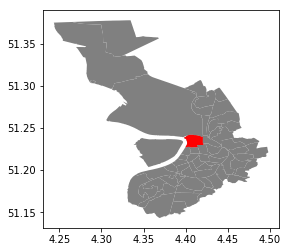

In [99]:
# Mark one area
area_name = 'Eilandje'
sample_area = areas.loc[areas['name']==area_name]
sample_area.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()
areas.plot(ax=ax, facecolor='gray');
sample_area.plot(ax=ax, facecolor='red');
plt.show();

## Filter data for chosen area

In [101]:
# Filter data for chosen area
pip_mask = gdf_district.within(sample_area.loc[0, 'geometry'])
pip_data = gdf_district.loc[pip_mask]
data = pip_data.copy()
data.head()

,_id,device,gateways,gpsLat,gpsLon,hdop,rx_time,seqNumber,spfact,coordinates,Area Name,Area ID
34,5c17b1544fa20f164de4b1b3,3432333855378A18,"[{'rssi': -117, 'esp': -119.430115, 'snr': 1, ...",51.230328,4.413255,0.95,2018-12-17 14:23:15.834,15672,7,POINT (4.413255214691162 51.23032760620117),Eilandje,6.0
36,5c17b1744fa20f164de4b1c4,3432333855378A18,"[{'rssi': -118, 'esp': -120.124428, 'snr': 2, ...",51.230518,4.413236,0.68,2018-12-17 14:23:47.671,15673,7,POINT (4.413236141204834 51.23051834106445),Eilandje,6.0
41,5c17b1b34fa20f164de4b1e5,3432333855378A18,"[{'rssi': -111, 'esp': -113.539017, 'snr': 1, ...",51.231632,4.409194,0.75,2018-12-17 14:24:50.658,15675,7,POINT (4.409194469451904 51.23163223266602),Eilandje,6.0
43,5c17b1d24fa20f164de4b1f6,3432333855378A18,"[{'rssi': -109, 'esp': -110.764351, 'snr': 3, ...",51.234451,4.409154,0.68,2018-12-17 14:25:22.933,15677,7,POINT (4.409154415130615 51.23445129394531),Eilandje,6.0
48,5c17b2114fa20f164de4b21a,3432333855378A18,"[{'rssi': -105, 'esp': -105.638924, 'snr': 8, ...",51.234451,4.409153,0.72,2018-12-17 14:26:25.023,15679,7,POINT (4.409152984619141 51.23445129394531),Eilandje,6.0


In [107]:
def scatter_one_day(year, month, day, data, dist_name):
    # Set startview for map
    mp = folium.Map(location=[data['gpsLat'].mean() ,data['gpsLon'].mean() ], 
                    zoom_start=15)

    # Generate legend
    legend_html = '''
         <div style="position: fixed; 
                     bottom: 50px; left: 50px; width: 100px; height: 150px; 
                     border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
                     ">&nbsp; <b> Legend </b> <br>
                     &nbsp; SPF 7 &nbsp; <i class="fa fa-circle" style="color:darkgreen"></i><br>
                     &nbsp; SPF 8 &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
                     &nbsp; SPF 9 &nbsp; <i class="fa fa-circle" style="color:yellow"></i><br>
                     &nbsp; SPF 10 &nbsp; <i class="fa fa-circle" style="color:orange"></i><br>
                     &nbsp; SPF 11 &nbsp; <i class="fa fa-circle" style="color:red"></i><br>
                     &nbsp; SPF 12 &nbsp; <i class="fa fa-circle" style="color:darkred"></i>
          </div>
         '''
    mp.get_root().html.add_child(folium.Element(legend_html))

    startDate = datetime(year, month, day, 0, 0); print(startDate)
    data_day = data[(data['rx_time'] > startDate) 
                                      & (data['rx_time'] < (startDate + timedelta(days=1)))]

    lat = list(data_day["gpsLat"])
    lon = list(data_day["gpsLon"])
    spf = list(data_day["spfact"])

    fg = folium.FeatureGroup(name=dist_name)
    for lt, ln, sp in zip(lat, lon, spf):
        cim = folium.CircleMarker(location=[lt, ln],
                                radius = 6,
                                popup="SPF: " +str(sp),
                                fill=True, # Set fill to True
                                fill_color=color_producer(sp),
                                color = color_producer(sp),
                                fill_opacity=0.7)
        fg.add_child(cim)

    mp.add_child(fg)

    delay=5

    #Save the map as an HTML file
    fn=str(dist_name)+startDate.strftime('%Y-%m-%d')+".html"
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    print(tmpurl)
    mp.save(fn)

    #Open a browser window...
#     browser = webdriver.Chrome('C:\\Users\\JeffG\\Downloads\\chromedriver_win32\\chromedriver.exe')
    browser = webdriver.Chrome('D:\\Downloads\\chromedriver_win32\\chromedriver.exe')
    #..that displays the map...
    browser.get(tmpurl)
    #Give the map tiles some time to load
    time.sleep(delay)
    #Grab the screenshot
    browser.save_screenshot(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\scripts\Case 2 - Bel-Air\Results\Visualizations' + '/' + str(dist_name)+startDate.strftime('%Y-%m-%d')+'.png')
    #Close the browser
    browser.quit()

## Test scatter plot for one day

In [108]:
# Test function for one day
scatter_one_day(2019,1,7,data,area_name)

2019-01-07 00:00:00
file://C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\scripts\Case 2 - Bel-Air/Eilandje2019-01-07.html


## Scatter plot for multiple days

In [ ]:
# Generate different scatter plots
#for i in range(1,32):
#    scatter_one_day(2018,12,i,data,area_name)

In [113]:
# Show resulting gif
from IPython.display import Image
from IPython.display import display
display(Image(url='SPF_Eilandje_cumul.gif'))
display(Image(url='SPF_Eilandje_single.gif'))

# Plot 6 - Generate hourly scatter plots for a certain grid area

In [ ]:
# Mark one area
grid_id = 45
sample_area = grid_areas.loc[grid_areas['cartodb_id']==grid_id]
sample_area.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()
grid_areas.plot(ax=ax, facecolor='gray');
sample_area.plot(ax=ax, facecolor='red');
plt.show();

In [ ]:
# Filter data for chosen area
pip_mask = gdf.within(sample_area.loc[0, 'geometry'])
pip_data = gdf.loc[pip_mask]
data = pip_data
data.head()

In [ ]:
def scatter_one_hour(year, month, day, hour, data, dist_id):
    # Set startview for map
    mp = folium.Map(location=[data['gpsLat'].mean() ,data['gpsLon'].mean() ], 
                    zoom_start=15)

    # Generate legend
    legend_html = '''
         <div style="position: fixed; 
                     bottom: 50px; left: 50px; width: 100px; height: 150px; 
                     border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
                     ">&nbsp; <b> Legend </b> <br>
                     &nbsp; SPF 7 &nbsp; <i class="fa fa-circle" style="color:darkgreen"></i><br>
                     &nbsp; SPF 8 &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
                     &nbsp; SPF 9 &nbsp; <i class="fa fa-circle" style="color:yellow"></i><br>
                     &nbsp; SPF 10 &nbsp; <i class="fa fa-circle" style="color:orange"></i><br>
                     &nbsp; SPF 11 &nbsp; <i class="fa fa-circle" style="color:red"></i><br>
                     &nbsp; SPF 12 &nbsp; <i class="fa fa-circle" style="color:darkred"></i>
          </div>
         '''
    mp.get_root().html.add_child(folium.Element(legend_html))

    startDate = datetime(year, month, day, hour, 0); print(startDate)
    data_hour = data[(data['rx_time'] > startDate) 
                                      & (data['rx_time'] < (startDate + timedelta(hours=1)))]

    lat = list(data_hour["gpsLat"])
    lon = list(data_hour["gpsLon"])
    spf = list(data_hour["spfact"])

    fg = folium.FeatureGroup(name=dist_id)
    for lt, ln, sp in zip(lat, lon, spf):
        cim = folium.CircleMarker(location=[lt, ln],
                                radius = 6,
                                popup="SPF: " +str(sp),
                                fill=True, # Set fill to True
                                fill_color=color_producer(sp),
                                color = color_producer(sp),
                                fill_opacity=0.7)
        fg.add_child(cim)

    mp.add_child(fg)

    delay=5

    #Save the map as an HTML file
    fn=str(dist_id)+startDate.strftime('%Y-%m-%d_%H%M')+".html"
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    print(tmpurl)
    mp.save(fn)

    #Open a browser window...
    browser = webdriver.Chrome('C:\\Users\\JeffG\\Downloads\\chromedriver_win32\\chromedriver.exe')
    #..that displays the map...
    browser.get(tmpurl)
    #Give the map tiles some time to load
    time.sleep(delay)
    #Grab the screenshot
    browser.save_screenshot('C:\\Users\\JeffG\\Documents\\Thesis\\Grid 45 - hourly\\' + 'dist_' + str(dist_id) +"_"+ startDate.strftime('%Y-%m-%d_%H%M')+'.png')
    #Close the browser
    browser.quit()

In [ ]:
# Test function for one day
scatter_one_hour(2019,1,7,13,data,grid_id)

In [ ]:
# for i in range(29,32):
#     for j in range(0,24):
#         scatter_one_hour(2018,12,i,j,data,grid_id)

In [ ]:
# Show resulting gif
from IPython.display import Image
from IPython.display import display
display(Image(url='SPF_Eilandje_cumul.gif'))

# Plot 7 - Heatmaps per SPF
These heatmaps just show where the majority of the data points are collected per spreading factor.

In [145]:
# Split data into frames for the different spreading factors
class_7 = df.loc[df['spfact'] == 7][['gpsLat','gpsLon']].values
class_8 = df.loc[df['spfact'] == 8][['gpsLat','gpsLon']].values
class_9 = df.loc[df['spfact'] == 9][['gpsLat','gpsLon']].values
class_10 = df.loc[df['spfact'] == 10][['gpsLat','gpsLon']].values
class_11 = df.loc[df['spfact'] == 11][['gpsLat','gpsLon']].values
class_12 = df.loc[df['spfact'] == 12][['gpsLat','gpsLon']].values

In [146]:
from folium.plugins import HeatMap

hm = folium.Map(location=[51.214618, 4.418419], 
                    zoom_start=13)

HeatMap(class_12).add_to(hm)

hm